In [1]:
import tensorflow as tf
import json, os
import numpy as np

# Tested with TensorFlow 2.1.0
print('version={}, CUDA={}, GPU={}, TPU={}'.format(
    tf.__version__, tf.test.is_built_with_cuda(),
    # GPU attached?
    len(tf.config.list_physical_devices('GPU')) > 0,
    # TPU accessible? (only works on Colab)
    'COLAB_TPU_ADDR' in os.environ))

version=2.1.0, CUDA=True, GPU=True, TPU=False


In [2]:
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

In [6]:
data_path = "/storage/ECAL/training_data/window_data/electrons/recordio_v1"
models_path = "/storage/ECAL/deepcluster/models/gcn_models"

In [8]:
# This dictionary specifies what "features" we want to extract from the
# tf.train.Example protos (i.e. what they look like on disk). We only
# need the image data "img_64" and the "label". Both features are tensors
# with a fixed length.
# You need to specify the correct "shape" and "dtype" parameters for
# these features.
feature_spec = {
}

seed_features = {
                    tf.float32: ["seed_eta", "seed_phi", "seed_iz", "en_seed", "et_seed" ] # "en_seed_calib", "et_seed_calib", 
               #     "seed_f5_r9","seed_f5_sigmaIetaIeta", "seed_f5_sigmaIetaIphi",
               #     "seed_f5_sigmaIphiIphi","seed_f5_swissCross","seed_etaWidth",
               #     "seed_phiWidth","seed_nxtals"]
}


for typ,flist in seed_features.items():
    for feat in flist:
        feature_spec[feat] = tf.io.FixedLenFeature(shape=[1], dtype=typ)

clusters_features = {   tf.int64 :["is_seed", "in_scluster","cl_nxtals"], 
                     tf.float32: ["d""cluster_dphi","en_cluster","et_cluster",  #"en_cluster_calib", "et_cluster_calib",
                               "cl_f5_r9", "cl_f5_sigmaIetaIeta", "cl_f5_sigmaIetaIphi",
                                "cl_f5_sigmaIphiIphi","cl_f5_swissCross","cl_etaWidth",
                                "cl_phiWidth"] }

for typ,flist in clusters_features.items():
    for feat in flist:
        feature_spec[feat] = tf.io.VarLenFeature(dtype=typ)
        

def parse_example(serialized_example):
  # Convert string to tf.train.Example and then extract features/label.
    features = tf.io.parse_single_example(serialized_example, feature_spec)
    
    seed_vars = []
    for typ, feats in seed_features.items():
        for f in feats:
            if f =="in_scluster":continue
            if typ == tf.int64:
                seed_vars.append(tf.sparse.to_dense(tf.cast(features[f], tf.float32)))
            else:
                seed_vars.append(features[f])
    
    seed_data = tf.transpose(seed_vars)
        
    to_be_stacked = []
    for typ, feats in clusters_features.items():
        for f in feats:
            if f =="in_scluster":continue
            if typ == tf.int64:
                to_be_stacked.append(tf.sparse.to_dense(tf.cast(features[f], tf.float32)))
            else:
                to_be_stacked.append(features[f].values)
                    
    data = tf.transpose(tf.stack(to_be_stacked))
    
    label = tf.expand_dims(tf.sparse.to_dense(tf.cast(features["in_scluster"],tf.float32)),1)
    
    return data, seed_data, label


In [9]:
batch_size = 10
n_features = 12
n_seed_features = 5
steps_per_epoch = 1e6 // batch_size
eval_steps_per_epoch = 3e5 // batch_size

# Create datasets from TFRecord files.
train_ds = tf.data.TFRecordDataset(tf.io.gfile.glob(
    '{}/training-*'.format(data_path)))
train_ds = train_ds.map(parse_example)
#train_ds = train_ds.padded_batch(batch_size, padded_shapes=([None,n_features],[None,n_seed_features], [None,1]),
#                                  padding_values=(0.,0.,0.),drop_remainder=True).repeat()

eval_ds = tf.data.TFRecordDataset(tf.io.gfile.glob(
    '{}/validation-*'.format(data_path)))
eval_ds = eval_ds.map(parse_example)
#eval_ds = eval_ds.padded_batch(batch_size, padded_shapes=([None,n_features],[None,n_seed_features],[None,1]),
#                                   padding_values=(0.,0.,0.),drop_remainder=True).repeat()


In [10]:
def dist(A,B):
    na = tf.reduce_sum(tf.square(A), 1)
    nb = tf.reduce_sum(tf.square(B), 1)

    na = tf.reshape(na, [-1, 1])
    nb = tf.reshape(nb, [1, -1])
    D = tf.sqrt(tf.maximum(na - 2*tf.matmul(A, B, False, True) + nb, 0.0))
    return D

In [11]:
class Distance(tf.keras.layers.Layer):

    def __init__(self, *args, **kwargs):
        super(Distance, self).__init__(*args, **kwargs)

    def call(self, inputs):
        
        #compute the pairwise distance matrix between the vectors defined by the first two components of the input array
        D =  dist(inputs[:, :2], inputs[:, :2])
        
        #closer nodes have higher weight, could also consider exp(-D) or such here
        D = tf.math.divide_no_nan(1.0, D)
        
        #turn edges on or off based on activation with an arbitrary shift parameter
        D = tf.keras.activations.sigmoid(D - 2.0)
        
        #keep only upper triangular matrix (unidirectional edges)
        D = tf.linalg.band_part(D, 0, -1)
        return D
    
class GraphConv(tf.keras.layers.Dense):
    def __init__(self, *args, **kwargs):
        super(GraphConv, self).__init__(*args, **kwargs)
    
    def call(self, inputs, adj):
        W = self.weights[0]
        b = self.weights[1]
        support = tf.matmul(inputs, W) + b
        out = tf.matmul(adj, support)
        return self.activation(out)

In [12]:
class DNNSuperCluster(tf.keras.Model):
    
    def __init__(self, activation=tf.keras.activations.relu, hidden_dim_in=256,hidden_dim_out=256):
        super(DNNSuperCluster, self).__init__()
        self.layer_input1 = tf.keras.layers.Dense(hidden_dim_in, activation=activation, name="input1")
        self.layer_input2 = tf.keras.layers.Dense(hidden_dim_in, activation=activation, name="input2")
        self.layer_input3 = tf.keras.layers.Dense(hidden_dim_in, activation=activation, name="input3")
        
        self.layer_dist = Distance(name="distance")
        self.layer_conv = GraphConv(hidden_dim_in, activation=activation, name="conv")
        
        self.layer_id1 = tf.keras.layers.Dense(hidden_dim_out, activation=activation, name="id1")
        self.layer_id2 = tf.keras.layers.Dense(hidden_dim_out, activation=activation, name="id2")
        self.layer_id3 = tf.keras.layers.Dense(hidden_dim_out, activation=activation, name="id3")
        self.layer_id = tf.keras.layers.Dense(1, activation="sigmoid", name="out_id")
        
        
    def call(self, inputs):
        #print(inputs)
        x_init = tf.concat([inputs[0],tf.broadcast_to(inputs[1],[inputs[0].shape[0], inputs[1].shape[1]] )],
                  axis=1)
        
        x = self.layer_input1(x_init)
        x = self.layer_input2(x)
        x_before_gcn = self.layer_input3(x)
        
        dm = self.layer_dist(x_before_gcn)
        #print("distance matrix:", dm.shape)
        x_gcn = self.layer_conv(x_before_gcn, dm)
        
        #print(x.shape)
        x_join = tf.concat([x_init, x_gcn], axis=1)
        
        a = self.layer_id1(x_join)
        a = self.layer_id2(a)
        a = self.layer_id3(a)
        out_id = self.layer_id(a)
    
        
        return out_id, dm

In [37]:
model = DNNSuperCluster(hidden_dim_in=100, hidden_dim_out=200)
opt = tf.keras.optimizers.Adam(lr=0.001)

In [17]:
model.summary()

Model: "dnn_super_cluster"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input1 (Dense)               multiple                  1800      
_________________________________________________________________
input2 (Dense)               multiple                  10100     
_________________________________________________________________
input3 (Dense)               multiple                  10100     
_________________________________________________________________
distance (Distance)          multiple                  0         
_________________________________________________________________
conv (GraphConv)             multiple                  10100     
_________________________________________________________________
id1 (Dense)                  multiple                  23600     
_________________________________________________________________
id2 (Dense)                  multiple            

In [26]:
idata = iter(train_ds)

In [15]:
ret = model(next(idata)[:2])

In [16]:
ret

(<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.2969414]], dtype=float32)>,
 <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.11920292]], dtype=float32)>)

In [19]:
import matplotlib.pyplot as plt

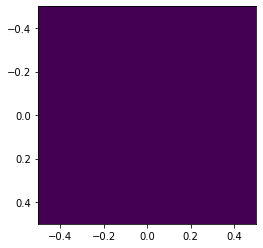

In [20]:
plt.imshow(ret[1])

In [21]:
def loss(model, inputs, targets):
    out, _ = model(inputs)
     # modified cross entropy to explicit mathematical formula of sigmoid cross entropy loss
    cross_entropy = - tf.reduce_sum( (  (targets[:,0]*tf.math.log(out + 1e-9)) + ((1-targets[:,0]) * tf.math.log(1 - out + 1e-9)) )  , name='xentropy' ) 
    
    return cross_entropy

In [33]:
d = next(idata)
loss(model, d[:2],d[2])

<tf.Tensor: shape=(), dtype=float32, numpy=71.99879>

In [34]:
def grad(model, inputs, targets, epoch):
    with tf.GradientTape() as tape:
        loss_value = loss(model, inputs, targets)
        return loss_value, tape.gradient(loss_value, model.trainable_variables)

In [ ]:
accum_vars = [tf.Variable(tf.zeros_like(tv.initialized_value()), trainable=False) for tv in model.trainable_variables]

for i in range(10):
    loss_tot = 0.0
    losses = []
    
    ibatch = 0
    
    true_y = []
    pred_y = []
    
    for ielem,train_data  in enumerate(train_ds):
        
        loss_value, grads = grad(model, train_data[:2],train_data[2], i)
        
        for igrad, gv in enumerate(grads):
            accum_vars[igrad].assign_add(gv)
        
        loss_tot += loss_value.numpy()
        if ibatch == 10:
            opt.apply_gradients([(accum_vars[igrad] / 10, model.trainable_variables[igrad]) for igrad in range(len(accum_vars))])
            ibatch = 0
            for igrad in range(len(accum_vars)):
                accum_vars[igrad].assign(tf.zeros_like(accum_vars[igrad]))
                
            losses.append(loss_tot)
            loss_tot = 0
        ibatch+=1

        if ielem % 250 == 0: 
            print(f"i: {ielem}, loss_tot: {np.mean(losses)}")
            losses.clear()
        
   

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


i: 0, loss_tot: nan
i: 250, loss_tot: 208.95696445910843
i: 500, loss_tot: 285.9967866801098
i: 750, loss_tot: 215.49208974038717
i: 1000, loss_tot: 235.45319188342896
i: 1250, loss_tot: 250.05417004236486
i: 1500, loss_tot: 270.592827648744
i: 1750, loss_tot: 239.17497981898487
i: 2000, loss_tot: 227.97677876235917
i: 2250, loss_tot: 246.68653825044632
i: 2500, loss_tot: 213.3957731453888
i: 2750, loss_tot: 225.02449972154574
i: 3000, loss_tot: 242.53036470352671
i: 3250, loss_tot: 235.186609955905
i: 3500, loss_tot: 240.67808114275337
i: 3750, loss_tot: 219.18794876560568
i: 4000, loss_tot: 186.38467956393959
i: 4250, loss_tot: 198.93314678423107
i: 4500, loss_tot: 224.8088186214678
i: 4750, loss_tot: 216.3698060000874
i: 5000, loss_tot: 212.80465302586555
i: 5250, loss_tot: 223.1398355620727
i: 5500, loss_tot: 237.8537559848884
i: 5750, loss_tot: 226.61613926644438
i: 6000, loss_tot: 265.59703569304196
i: 6250, loss_tot: 224.47560287389905
i: 6500, loss_tot: 297.88556430969385
i: 67

i: 53500, loss_tot: 196.63222378241247
i: 53750, loss_tot: 243.57906349463389
i: 54000, loss_tot: 194.37196313572232
i: 54250, loss_tot: 187.90204194065183
i: 54500, loss_tot: 205.80359384701586
i: 54750, loss_tot: 183.49203126790235
i: 55000, loss_tot: 218.31527184729464
i: 55250, loss_tot: 207.90454569417983
i: 55500, loss_tot: 223.5672454131278
i: 55750, loss_tot: 206.1351486755861
i: 56000, loss_tot: 223.97713837882503
i: 56250, loss_tot: 197.50786902117542
i: 56500, loss_tot: 239.7570540627511
i: 56750, loss_tot: 244.33578633099793
i: 57000, loss_tot: 277.9544284191914
i: 57250, loss_tot: 230.16044629218058
i: 57500, loss_tot: 264.22975816995836
i: 57750, loss_tot: 277.35292240699755
i: 58000, loss_tot: 239.65496104590594
i: 58250, loss_tot: 181.84221364041093
i: 58500, loss_tot: 244.8915189059172
i: 58750, loss_tot: 219.90682541863293
i: 59000, loss_tot: 193.96386425940784
i: 59250, loss_tot: 265.65226422782985
i: 59500, loss_tot: 196.30504738237244
i: 59750, loss_tot: 229.379449

i: 106500, loss_tot: 253.46463328302255
i: 106750, loss_tot: 232.4778765048599
i: 107000, loss_tot: 237.55550339414492
i: 107250, loss_tot: 199.33844076780215
i: 107500, loss_tot: 227.90935976129012
i: 107750, loss_tot: 212.662644226775
i: 108000, loss_tot: 200.689330088367
i: 108250, loss_tot: 204.69631796650035
i: 108500, loss_tot: 213.89729173250518
i: 108750, loss_tot: 214.47074522374896
i: 109000, loss_tot: 216.17597608039156
i: 109250, loss_tot: 261.8982407411188
i: 109500, loss_tot: 230.42022186422022
i: 109750, loss_tot: 194.53987273549194
i: 110000, loss_tot: 242.0785566044299
i: 110250, loss_tot: 186.47825439905458
i: 110500, loss_tot: 218.49419141830526
i: 110750, loss_tot: 232.53813643434552
i: 111000, loss_tot: 180.18275376212785
i: 111250, loss_tot: 258.1342973970529
i: 111500, loss_tot: 221.78341306778603
i: 111750, loss_tot: 185.02807533215963
i: 112000, loss_tot: 186.2398552709166
i: 112250, loss_tot: 226.5505964107241
i: 112500, loss_tot: 251.79410597045907
i: 112750,

i: 158250, loss_tot: 273.79737309615825
i: 158500, loss_tot: 248.39857039453753
i: 158750, loss_tot: 208.63610787773302
i: 159000, loss_tot: 316.11544759259186
i: 159250, loss_tot: 193.68333580251667
i: 159500, loss_tot: 210.07463427734382
i: 159750, loss_tot: 246.67457502349106
i: 160000, loss_tot: 253.46721022756654
i: 160250, loss_tot: 205.53194766984322
i: 160500, loss_tot: 191.24232087644734
i: 160750, loss_tot: 218.69996197019486
i: 161000, loss_tot: 228.9686958142108
i: 161250, loss_tot: 219.2850498936884
i: 161500, loss_tot: 264.9396471658862
i: 161750, loss_tot: 244.04483930122223
i: 162000, loss_tot: 271.2400824238178
i: 162250, loss_tot: 285.34641656265376
i: 162500, loss_tot: 214.04839830499157
i: 162750, loss_tot: 192.1898056708055
i: 163000, loss_tot: 197.22354000536316
i: 163250, loss_tot: 220.59410395575352
i: 163500, loss_tot: 252.3521079925273
i: 163750, loss_tot: 270.7512111997148
i: 164000, loss_tot: 228.71704006306743
i: 164250, loss_tot: 202.03034034657657
i: 1645

i: 210000, loss_tot: 222.7471588911602
i: 210250, loss_tot: 183.03838891014274
i: 210500, loss_tot: 193.65115287433292
i: 210750, loss_tot: 220.9447257387539
i: 211000, loss_tot: 217.434254175684
i: 211250, loss_tot: 242.28324966440073
i: 211500, loss_tot: 241.8408116125554
i: 211750, loss_tot: 213.20688717036035
i: 212000, loss_tot: 227.59499197501617
i: 212250, loss_tot: 266.4525665788702
i: 212500, loss_tot: 185.8044412558712
i: 212750, loss_tot: 221.8470372599177
i: 213000, loss_tot: 258.8392713886686
i: 213250, loss_tot: 215.03873767830083
i: 213500, loss_tot: 259.9296202967211
i: 213750, loss_tot: 211.95198286492334
i: 214000, loss_tot: 228.7366633171242
i: 214250, loss_tot: 229.68746061634738
i: 214500, loss_tot: 198.28430455778727
i: 214750, loss_tot: 252.816833384966
i: 215000, loss_tot: 194.0183695360448
i: 215250, loss_tot: 221.2670339269936
i: 215500, loss_tot: 196.745967968732
i: 215750, loss_tot: 202.27537264494342
i: 216000, loss_tot: 220.33957548440435
i: 216250, loss_t

i: 266250, loss_tot: 209.35218253486033
i: 266500, loss_tot: 234.86459394401405
i: 266750, loss_tot: 235.6737697120104
i: 267000, loss_tot: 204.96482680415974
i: 267250, loss_tot: 223.33002493123666
i: 267500, loss_tot: 184.0261989990752
i: 267750, loss_tot: 292.46440382585394
i: 268000, loss_tot: 230.92876323651058
i: 268250, loss_tot: 205.66398739330475
i: 268500, loss_tot: 215.27962574399666
i: 268750, loss_tot: 208.13157042921682
i: 269000, loss_tot: 210.82508225417746
i: 269250, loss_tot: 209.32847899821164
i: 269500, loss_tot: 216.28452451244462
i: 269750, loss_tot: 194.59091387503156
i: 270000, loss_tot: 219.7087647319294
i: 270250, loss_tot: 241.5018296864361
i: 270500, loss_tot: 282.5670000299276
i: 270750, loss_tot: 237.26457983915301
i: 271000, loss_tot: 229.99471291558402
i: 271250, loss_tot: 255.77943326419975
i: 271500, loss_tot: 263.116213252666
i: 271750, loss_tot: 227.15781768480315
i: 272000, loss_tot: 221.3135668900609
i: 272250, loss_tot: 216.53604675164502
i: 27250

i: 318000, loss_tot: 269.99567874162545
i: 318250, loss_tot: 241.89107630460876
i: 318500, loss_tot: 220.33105245762505
i: 318750, loss_tot: 192.34491530579984
i: 319000, loss_tot: 245.5514203167407
i: 319250, loss_tot: 287.9513078546431
i: 319500, loss_tot: 246.99633468367648
i: 319750, loss_tot: 228.20283182969084
i: 320000, loss_tot: 217.74233141831553
i: 320250, loss_tot: 264.5350873042088
i: 320500, loss_tot: 270.1095783567056
i: 320750, loss_tot: 226.19536688216874
i: 321000, loss_tot: 217.97877684553387
i: 321250, loss_tot: 266.6009068709984
i: 321500, loss_tot: 266.7936446601525
i: 321750, loss_tot: 226.38896571927705
i: 322000, loss_tot: 242.1235203309142
i: 322250, loss_tot: 239.81798603355884
i: 322500, loss_tot: 207.75538106399122
i: 322750, loss_tot: 196.68540845136624
i: 323000, loss_tot: 213.19955634166033
i: 323250, loss_tot: 200.49027486378793
i: 323500, loss_tot: 195.1898364117249
i: 323750, loss_tot: 269.57051966620025
i: 324000, loss_tot: 225.17033428942545
i: 32425

i: 369750, loss_tot: 194.24152920999563
i: 370000, loss_tot: 182.58172116332338
i: 370250, loss_tot: 231.23096923257725
i: 370500, loss_tot: 283.2724883945932
i: 370750, loss_tot: 206.64300570157357
i: 371000, loss_tot: 262.7844821895333
i: 371250, loss_tot: 222.65236459279956
i: 371500, loss_tot: 298.79554905761967
i: 371750, loss_tot: 237.23705197622039
i: 372000, loss_tot: 247.72032625796274
i: 372250, loss_tot: 233.64993213991775
i: 372500, loss_tot: 221.3519018962351
i: 372750, loss_tot: 263.10924500637555
i: 373000, loss_tot: 208.96542186162435
i: 373250, loss_tot: 302.8299050919805
i: 373500, loss_tot: 205.52417205245473
i: 373750, loss_tot: 239.72813794603746
i: 374000, loss_tot: 231.44082982542005
i: 374250, loss_tot: 251.5471491848817
i: 374500, loss_tot: 239.97566145770486
i: 374750, loss_tot: 211.43668203861336
i: 375000, loss_tot: 219.7385301554494
i: 375250, loss_tot: 255.89885393107193
i: 375500, loss_tot: 228.5114612720249
i: 375750, loss_tot: 227.48795843144063
i: 3760

i: 421500, loss_tot: 192.91261483535826
i: 421750, loss_tot: 198.10933042709163
i: 422000, loss_tot: 199.17323544760526
i: 422250, loss_tot: 262.10665336568604
i: 422500, loss_tot: 224.64865237947393
i: 422750, loss_tot: 215.84224806705498
i: 423000, loss_tot: 201.20374926334028
i: 423250, loss_tot: 192.12329652740854
i: 423500, loss_tot: 203.78832149479538
i: 423750, loss_tot: 237.79375486987877
i: 424000, loss_tot: 195.5482828497386
i: 424250, loss_tot: 216.2961102392059
i: 424500, loss_tot: 268.76809307730406
i: 424750, loss_tot: 256.4623376817955
i: 425000, loss_tot: 200.96182286016642
i: 425250, loss_tot: 204.5081690647977
i: 425500, loss_tot: 219.10530454760794
i: 425750, loss_tot: 235.08093105787236
i: 426000, loss_tot: 189.16731302413623
i: 426250, loss_tot: 203.1894930001264
i: 426500, loss_tot: 252.85371015694938
i: 426750, loss_tot: 225.7047546628173
i: 427000, loss_tot: 248.34073927908204
i: 427250, loss_tot: 201.93739238508715
i: 427500, loss_tot: 249.60772844757537
i: 427

i: 473250, loss_tot: 234.6087592701876
i: 473500, loss_tot: 197.51954417627292
i: 473750, loss_tot: 193.08571952223602
i: 474000, loss_tot: 226.3472908866241
i: 474250, loss_tot: 228.9739955358388
i: 474500, loss_tot: 244.37644655471087
i: 474750, loss_tot: 249.35751154112745
i: 475000, loss_tot: 203.6333217321722
i: 475250, loss_tot: 190.15045345163205
i: 475500, loss_tot: 198.21782716457733
i: 475750, loss_tot: 184.72904053182108
i: 476000, loss_tot: 197.43575902521647
i: 476250, loss_tot: 189.6902693167718
i: 476500, loss_tot: 224.86319404133815
i: 476750, loss_tot: 268.68124966877514
i: 477000, loss_tot: 243.3114087085225
i: 477250, loss_tot: 234.23193274776452
i: 477500, loss_tot: 237.5082333750045
i: 477750, loss_tot: 259.30738658715285
i: 478000, loss_tot: 257.81568934388457
i: 478250, loss_tot: 221.9681905891378
i: 478500, loss_tot: 249.1407658706262
i: 478750, loss_tot: 295.4352917330675
i: 479000, loss_tot: 232.0988411292249
i: 479250, loss_tot: 242.4104537615714
i: 479500, l

i: 525000, loss_tot: 215.64893132783575
i: 525250, loss_tot: 218.4641618114186
i: 525500, loss_tot: 222.0314932494838
i: 525750, loss_tot: 223.77845084885456
i: 526000, loss_tot: 180.52128949994454
i: 526250, loss_tot: 222.80871001239052
i: 526500, loss_tot: 207.36412023667668
i: 526750, loss_tot: 248.59857952344962
i: 527000, loss_tot: 232.36229851009332
i: 527250, loss_tot: 267.6980154099376
i: 527500, loss_tot: 268.18861017156394
i: 527750, loss_tot: 251.8099386283281
i: 528000, loss_tot: 225.8331625523651
i: 528250, loss_tot: 247.97563554794408
i: 528500, loss_tot: 211.58799455771222
i: 528750, loss_tot: 209.16452857160476
i: 529000, loss_tot: 253.62148275386397
i: 529250, loss_tot: 244.97738266725514
i: 529500, loss_tot: 205.6396378662905
i: 529750, loss_tot: 202.65135761235956
i: 530000, loss_tot: 243.2207071040501
i: 530250, loss_tot: 203.9787352422066
i: 530500, loss_tot: 205.23582799309864
i: 530750, loss_tot: 261.36598081196195
i: 531000, loss_tot: 230.96871236183102
i: 53125

i: 576750, loss_tot: 262.9644492306281
i: 577000, loss_tot: 268.5376177310664
i: 577250, loss_tot: 189.55169617084786
i: 577500, loss_tot: 199.54723428823053
i: 577750, loss_tot: 242.69521252424457
i: 578000, loss_tot: 270.31080128835515
i: 578250, loss_tot: 197.70752793615802
i: 578500, loss_tot: 231.74930546165444
i: 578750, loss_tot: 241.2502410798148
i: 579000, loss_tot: 261.1486596222785
i: 579250, loss_tot: 210.3658348857169
i: 579500, loss_tot: 206.8673452442825
i: 579750, loss_tot: 187.77929957350017
i: 580000, loss_tot: 209.40448521762076
i: 580250, loss_tot: 197.9746032600222
i: 580500, loss_tot: 171.59750246102863
i: 580750, loss_tot: 208.41313536195085
i: 581000, loss_tot: 293.07122738131324
i: 581250, loss_tot: 192.96526285238332
i: 581500, loss_tot: 248.50760428451002
i: 581750, loss_tot: 197.31304269610075
i: 582000, loss_tot: 210.24056498820428
i: 582250, loss_tot: 242.51875421423466
i: 582500, loss_tot: 212.28686331769453
i: 582750, loss_tot: 237.9307080650609
i: 58300

i: 628500, loss_tot: 257.70720541239297
i: 628750, loss_tot: 198.93611151242908
i: 629000, loss_tot: 221.76173611864854
i: 629250, loss_tot: 171.97616132064277
i: 629500, loss_tot: 191.99172647357946
i: 629750, loss_tot: 303.6225040785955
i: 630000, loss_tot: 215.92240322075784
i: 630250, loss_tot: 263.3211314351205
i: 630500, loss_tot: 213.256870596895
i: 630750, loss_tot: 204.074246023288
i: 631000, loss_tot: 223.0984052023245
i: 631250, loss_tot: 216.0044294408965
i: 631500, loss_tot: 216.1279933447392
i: 631750, loss_tot: 242.80647651409294
i: 632000, loss_tot: 222.20492712593753
i: 632250, loss_tot: 294.89105797845536
i: 632500, loss_tot: 249.31122063362972
i: 632750, loss_tot: 254.70223384037257
i: 633000, loss_tot: 245.1876728801978
i: 633250, loss_tot: 207.58274408710383
i: 633500, loss_tot: 228.4439568282677
i: 633750, loss_tot: 278.3643546783371
i: 634000, loss_tot: 223.5838115686305
i: 634250, loss_tot: 224.8450546283461
i: 634500, loss_tot: 227.79137141697575
i: 634750, los

i: 680250, loss_tot: 235.7081776235478
i: 680500, loss_tot: 185.38965827423715
i: 680750, loss_tot: 199.45094057596987
i: 681000, loss_tot: 193.28871465354226
i: 681250, loss_tot: 205.82278908068926
i: 681500, loss_tot: 236.59931544080945
i: 681750, loss_tot: 220.92916982158087
i: 682000, loss_tot: 211.33308540992803
i: 682250, loss_tot: 174.6438211685809
i: 682500, loss_tot: 255.60148853124775
i: 682750, loss_tot: 205.09937022564466
i: 683000, loss_tot: 211.2707136230392
i: 683250, loss_tot: 257.3594926194951
i: 683500, loss_tot: 224.01556247266709
i: 683750, loss_tot: 219.68179311581716
i: 684000, loss_tot: 224.8729581945989
i: 684250, loss_tot: 240.55369103688395
i: 684500, loss_tot: 290.28361140673513
i: 684750, loss_tot: 231.9563404605447
i: 685000, loss_tot: 241.9770468857579
i: 685250, loss_tot: 232.04038588774623
i: 685500, loss_tot: 251.14558771303157
i: 685750, loss_tot: 227.97496338438702
i: 686000, loss_tot: 242.81701503974662
i: 686250, loss_tot: 204.222683371288
i: 686500

i: 732000, loss_tot: 242.1328905795864
i: 732250, loss_tot: 261.1886766362407
i: 732500, loss_tot: 200.52382099415422
i: 732750, loss_tot: 231.05283008014877
i: 733000, loss_tot: 235.14296671147866
i: 733250, loss_tot: 215.01136665513738
i: 733500, loss_tot: 254.73607313103042
i: 733750, loss_tot: 200.0551202340611
i: 734000, loss_tot: 181.37243620429973
i: 734250, loss_tot: 208.24793758187886
i: 734500, loss_tot: 200.17104453943233
i: 734750, loss_tot: 224.4338899835949
i: 735000, loss_tot: 186.53052984432202
i: 735250, loss_tot: 262.675071992349
i: 735500, loss_tot: 187.68043664181585
i: 735750, loss_tot: 210.18815524434504
i: 736000, loss_tot: 243.1117938328475
i: 736250, loss_tot: 286.387861172393
i: 736500, loss_tot: 196.5787823777643
i: 736750, loss_tot: 199.6312133125128
i: 737000, loss_tot: 185.5373161366023
i: 737250, loss_tot: 196.85254964414634
i: 737500, loss_tot: 233.19173012615997
i: 737750, loss_tot: 217.26445704846643
i: 738000, loss_tot: 211.74113845386398
i: 738250, l

i: 783750, loss_tot: 252.0923607951775
i: 784000, loss_tot: 236.01040406699292
i: 784250, loss_tot: 210.1004590171591
i: 784500, loss_tot: 177.3131952783402
i: 784750, loss_tot: 258.39702489283866
i: 785000, loss_tot: 208.47682026490568
i: 785250, loss_tot: 233.00928222691655
i: 785500, loss_tot: 227.41214659516467
i: 785750, loss_tot: 217.00513230351265
i: 786000, loss_tot: 254.49746485879018
i: 786250, loss_tot: 249.03764483374778
i: 786500, loss_tot: 231.95978598975
i: 786750, loss_tot: 222.3941777442385
i: 787000, loss_tot: 218.68668966561555
i: 787250, loss_tot: 266.04199720268
i: 787500, loss_tot: 218.64470007103645
i: 787750, loss_tot: 225.9509102216782
i: 788000, loss_tot: 247.47913627818227
i: 788250, loss_tot: 201.29257585125043
i: 788500, loss_tot: 230.26306699693203
i: 788750, loss_tot: 229.1577421088308
i: 789000, loss_tot: 201.26149965959144
i: 789250, loss_tot: 160.07087806764991
i: 789500, loss_tot: 251.21789539947233
i: 789750, loss_tot: 253.58057788004172
i: 790000, l

In [42]:
model.save_weights(f"{models_path}/model_v1")

In [ ]:
 
    true_ids_testing = []
    pred_ids_testing = []
    loss_tot_testing = 0.0
    for Xelem, ygen in zip(Xs_testing, ys_testing):
        pred_id, pred_momentum, _ = model(Xelem)
        true_ids_testing += [ygen[:, 0]]
        pred_ids_testing += [tf.argmax(pred_id, axis=-1).numpy()]
    true_ids_testing = np.concatenate(true_ids_testing)
    pred_ids_testing = np.concatenate(pred_ids_testing)

    acc = accuracy_score(true_ids, pred_ids)
    acc_testing = accuracy_score(true_ids_testing, pred_ids_testing)
    print("epoch={epoch} loss={loss:.2f} acc={acc:.4f}/{acc_testing:.4f}".format(epoch=i, loss=loss_tot, acc=acc, acc_testing=acc_testing))

In [196]:
d = next(idata)
grad(model, d[:2], d[2],2)

(<tf.Tensor: shape=(), dtype=float32, numpy=33.82944>,
 [<tf.Tensor: shape=(17, 256), dtype=float32, numpy=
  array([[-6.5652908e-05,  1.8222781e-04,  1.3736475e-04, ...,
           0.0000000e+00, -2.7843516e-05,  1.5871467e-04],
         [ 3.4128204e-03,  8.1344908e-03,  3.4933211e-03, ...,
           0.0000000e+00, -1.2456551e-03,  3.2668163e-03],
         [ 1.3817850e-04,  2.3852444e-04, -2.9617239e-04, ...,
           0.0000000e+00, -3.2318136e-04, -1.2414173e-04],
         ...,
         [-2.8638414e-03, -6.8506207e-03, -1.9610510e-03, ...,
           0.0000000e+00,  1.2414590e-03, -2.3893260e-03],
         [ 3.7812863e-02,  9.0452485e-02,  2.5892826e-02, ...,
           0.0000000e+00, -1.6391661e-02,  3.1547576e-02],
         [ 5.9031565e-03,  1.4120994e-02,  4.0422594e-03, ...,
           0.0000000e+00, -2.5589848e-03,  4.9250508e-03]], dtype=float32)>,
  <tf.Tensor: shape=(256,), dtype=float32, numpy=
  array([ 2.8638414e-03,  6.8506207e-03,  1.9610510e-03,  0.0000000e+00,
     

In [313]:
history = model.fit(  train_ds,
                    validation_data = eval_ds,
                   steps_per_epoch = steps_per_epoch,
                   validation_steps = eval_steps_per_epoch,
                   epochs=5,
                   verbose=True)

Train for 5000.0 steps, validate for 1500.0 steps
Epoch 1/5
5000/5000 [==============================] - 552s 110ms/step - loss: 0.0426 - accuracy: 0.9540 - AUC: 0.9616 - val_loss: 0.0391 - val_accuracy: 0.9570 - val_AUC: 0.9685
Epoch 2/5
5000/5000 [==============================] - 550s 110ms/step - loss: 0.0385 - accuracy: 0.9573 - AUC: 0.9691 - val_loss: 0.0384 - val_accuracy: 0.9576 - val_AUC: 0.9695
Epoch 3/5
5000/5000 [==============================] - 549s 110ms/step - loss: 0.0378 - accuracy: 0.9580 - AUC: 0.9702 - val_loss: 0.0372 - val_accuracy: 0.9588 - val_AUC: 0.9715
Epoch 4/5
5000/5000 [==============================] - 551s 110ms/step - loss: 0.0367 - accuracy: 0.9591 - AUC: 0.9719 - val_loss: 0.0362 - val_accuracy: 0.9598 - val_AUC: 0.9731
Epoch 5/5
5000/5000 [==============================] - 552s 110ms/step - loss: 0.0359 - accuracy: 0.9599 - AUC: 0.9733 - val_loss: 0.0357 - val_accuracy: 0.9602 - val_AUC: 0.9743


In [316]:
model.save(models_path+"/model_v1.h5")